# PROJECT: DATA LAKE
## ETL PIPELINE FOR SPARKIFY DATABASE - DATA LAKE ON S3
## PART 3: DEMO THE USAGE OF SPARKIFY DATABASE

### by Tran Nguyen

## 1. INTRODUCTION ABOUT THE SPARKIFY DATABASE

- Sparkify is a startup company working on a music streaming app. Through the app, Sparkify has collected information about user activity and songs, which is stored as a directory of JSON logs (`log_data` - user activity) and a directory of JSON metadata files (`song_data` - song information). These data resides in S3 on AWS.
- In order to improve the business growth, Sparkify wants to move their processes and data onto the data lake on the cloud.
- This project would be a workflow to explore and build an ETL pipeline that extracts the data from S3, processes the data into analytics tables using Spark on an AWS cluster, and loads the data back into S3 as a set of dimensional tables for the Sparkify analytics team to continue finding insights in what songs their users are listening to.

- This notebook provides example queries and results for song play analysis using Spark.

- Here is the ERD of `sparkifydb`:

<img src="ERD_datalake.png" width="600">

## 2. SET UP SPARK SESSION

In [1]:
### Import all the necessary packages
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from datetime import datetime
from pyspark.sql.functions import col, max as max_
from pyspark.sql.functions import *
from time import time
import os
import configparser
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1. LOAD AWS CREDENTIALS

In [2]:
### Read config file
config = configparser.ConfigParser()
config.read('credentials.cfg')
# Retrieve value using config['KEYWORD']['SUBKEYWORD']
os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['AWS_SECRET_ACCESS_KEY']

### 2.2. CREATE SPARK SESSION WITH HADOOP-AWS PACKAGE

In [3]:
spark = SparkSession.builder\
                     .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
                     .getOrCreate()
### The package `org.apache.hadoop:hadoop-aws:2.7.0` allows you to connect aws S3.

### 2.3. LOADING ALL THE TABLES

In [6]:
#input_path = 'output' # location of all the tables
input_path ='s3a://datalake-s3'
tables = ['songs', 'artists', 'users', 'time', 'songplays']

In [7]:
### load all the tables, list the rows in each table and convert tables into sql tables for analysis
i = 0
for i, table in enumerate(tables):
    table_name = os.path.join(input_path, table)
    parquetFile = spark.read.parquet(table_name)
    ### print count
    print(f"Number of row of the table {table}: {parquetFile.count()}") 
    
    ### convert df to sql table
    parquetFile.createOrReplaceTempView(table)

Number of row of the table songs: 14896
Number of row of the table artists: 10025
Number of row of the table users: 96
Number of row of the table time: 6813
Number of row of the table songplays: 6820


## 3. SOME DATA ANALYSIS

##### THE NUMBER OF SONGPLAYS FROM DIFFERENT LEVEL GROUP

In [8]:
### The number of songplay by different level
query = """
SELECT level, COUNT(*) Count 
FROM songplays 
GROUP BY level 
ORDER BY Count DESC LIMIT 10;
"""
result = spark.sql(query)
result.show()

+-----+-----+
|level|Count|
+-----+-----+
| paid| 5591|
| free| 1229|
+-----+-----+



In [9]:
type(result)

pyspark.sql.dataframe.DataFrame

In [11]:
result_df = result.toPandas().set_index('level')
result_df

,Count
level,
paid,5591
free,1229


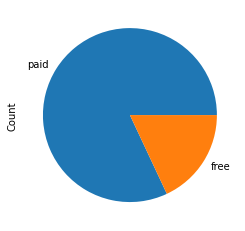

In [12]:
result_df.plot.pie(y = 'Count', figsize = (4,4), legend = False);

#### TOP 10 USERS WHO LISTENING TO THE MOST IN THIS DATA PERIOD

In [13]:
query = """
SELECT s.user_id, u.gender, u.level, s.location, COUNT(*) total 
FROM songplays s
JOIN users u
ON s.user_id = u.user_id
GROUP BY s.user_id, u.gender, u.level, s.location
ORDER BY total DESC 
LIMIT 10;
"""
top_users_df = spark.sql(query).toPandas()

In [14]:
top_users_df.style.background_gradient(cmap = 'Greens', subset = ['total'])

,user_id,gender,level,location,total
0,49,F,paid,"San Francisco-Oakland-Hayward, CA",689
1,80,F,paid,"Portland-South Portland, ME",665
2,97,F,paid,"Lansing-East Lansing, MI",557
3,15,F,paid,"Chicago-Naperville-Elgin, IL-IN-WI",463
4,44,F,paid,"Waterloo-Cedar Falls, IA",397
5,29,F,paid,"Atlanta-Sandy Springs-Roswell, GA",346
6,24,F,paid,"Lake Havasu City-Kingman, AZ",321
7,73,M,paid,"Tampa-St. Petersburg-Clearwater, FL",289
8,88,M,paid,"Sacramento--Roseville--Arden-Arcade, CA",270
9,36,M,paid,"Janesville-Beloit, WI",248


##### LOCATION THAT HAS MOST USERS

In [15]:
query = """
SELECT s.user_id, u.gender, u.level, s.location, COUNT(*) total 
FROM songplays s
JOIN users u
ON s.user_id = u.user_id
GROUP BY s.user_id, u.gender, u.level, s.location
ORDER BY total DESC 
LIMIT 10;
"""
top_location_df = spark.sql(query).toPandas()

In [16]:
top_location_df.style.background_gradient(cmap = 'Greens', subset = ['total'])

,user_id,gender,level,location,total
0,49,F,paid,"San Francisco-Oakland-Hayward, CA",689
1,80,F,paid,"Portland-South Portland, ME",665
2,97,F,paid,"Lansing-East Lansing, MI",557
3,15,F,paid,"Chicago-Naperville-Elgin, IL-IN-WI",463
4,44,F,paid,"Waterloo-Cedar Falls, IA",397
5,29,F,paid,"Atlanta-Sandy Springs-Roswell, GA",346
6,24,F,paid,"Lake Havasu City-Kingman, AZ",321
7,73,M,paid,"Tampa-St. Petersburg-Clearwater, FL",289
8,88,M,paid,"Sacramento--Roseville--Arden-Arcade, CA",270
9,36,M,paid,"Janesville-Beloit, WI",248


#### TIME ANALYSIS

##### WEEKDAY DISTRIBUTION

- `weekday` column contain an integer from 0–6, starting with Sunday.

In [17]:
query = """
SELECT weekday, COUNT(weekday) count 
FROM time
GROUP BY weekday 
ORDER BY count DESC
"""
wday_dist_df = spark.sql(query).toPandas()
wday_dist_df

,weekday,count
0,Wed,1361
1,Fri,1294
2,Tue,1070
3,Thu,1051
4,Mon,1014
5,Sat,627
6,Sun,396


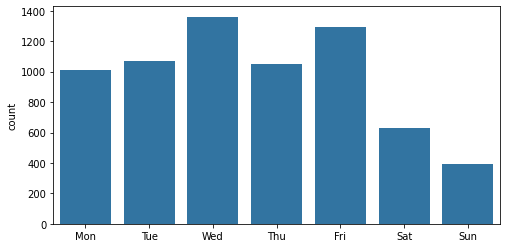

In [18]:
### Set categorical variables into the right order for beautiful plotting
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dayclass = pd.api.types.CategoricalDtype(ordered = True, categories = days)
wday_dist_df['weekday'] = wday_dist_df['weekday'].astype(dayclass)
# Plot
colors = sns.color_palette()
plt.figure(figsize = (8,4))
sns.barplot(wday_dist_df['weekday'], wday_dist_df['count'], color = colors[0]);
plt.xlabel('');

##### HOUR DISTRIBUTION

In [19]:
query = """
SELECT hour, COUNT(hour) count 
FROM time
GROUP BY hour 
ORDER BY hour ASC
"""
hour_dist_df = spark.sql(query).toPandas()
hour_dist_df.head(3)

,hour,count
0,0,155
1,1,154
2,2,117


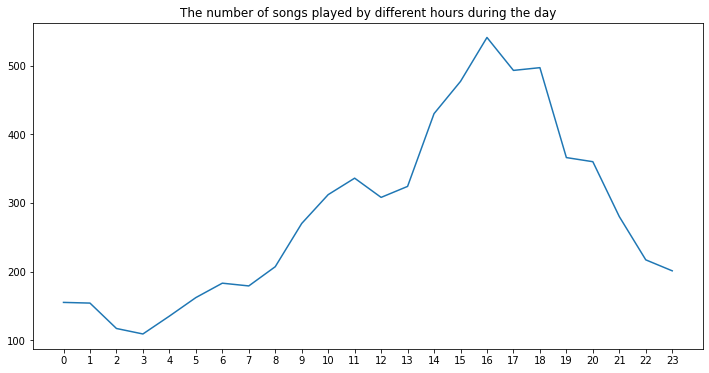

In [20]:
plt.figure(figsize = (12, 6))
plt.plot(hour_dist_df['hour'], hour_dist_df['count'])
plt.title('The number of songs played by different hours during the day')
plt.xticks(hour_dist_df['hour'], hour_dist_df['hour']);

In [21]:
query = """
SELECT weekday, hour, COUNT(hour) hour_count 
FROM time
GROUP BY weekday, hour 
ORDER BY hour ASC
"""
day_hour_dist_df = spark.sql(query).toPandas()
day_hour_dist_df.head()

,weekday,hour,hour_count
0,Mon,0,6
1,Thu,0,34
2,Wed,0,38
3,Tue,0,20
4,Fri,0,37


In [22]:
### Set categorical variables into the right order for beautiful plotting
day_hour_dist_df['weekday'] = day_hour_dist_df['weekday'].astype(dayclass)

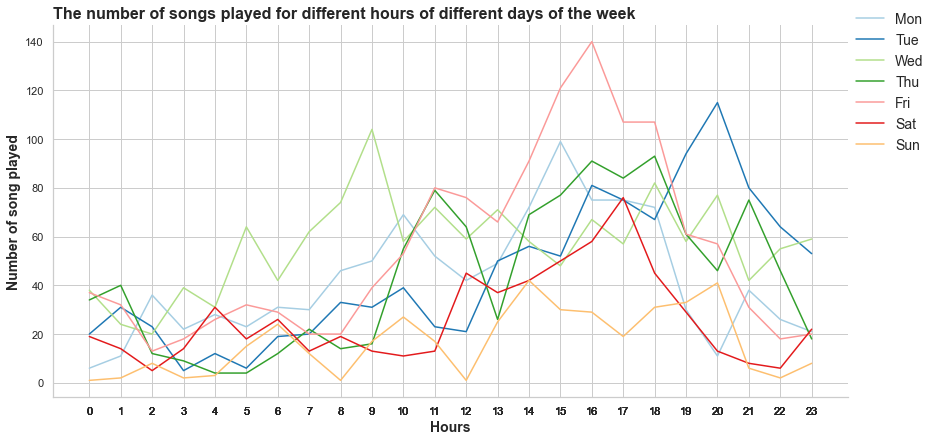

In [23]:
sns.set(style="whitegrid")
g = sns.FacetGrid(data = day_hour_dist_df, hue = 'weekday',
                  hue_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                  palette = 'Paired', height = 6, aspect = 2)
g.map(plt.plot, 'hour', 'hour_count')\
        .set(xticks= day_hour_dist_df.hour);
plt.ylabel('Number of song played', fontsize = 14, fontweight = 'bold')
g.add_legend(loc = 'upper right', title = '', fontsize='14');
plt.xlabel('Hours', fontsize = 14, fontweight = 'bold')
plt.title('The number of songs played for different hours of different days of the week', \
              loc = 'left', fontsize = 16, fontweight = 'bold');

End of demo.